# Experiment 3: Adamic-Adar Metric Backbone on Flickr

This notebook extends our sparsification research to the **Flickr** social network, which contains **89,250 nodes** and **≈900,000 edges**—a medium-scale dataset that sits between citation networks (Cora/PubMed) and massive social graphs (Reddit).

## Research Context & Objective

**Problem.** Graph Neural Networks (GNNs) become computationally expensive on large graphs because message passing scales with the number of edges: complexity is typically $O(|E|)$. While Flickr's ~900k edges are tractable, exploring sparsification helps us understand redundancy in social networks.

**Hypothesis.** Social networks like Flickr exhibit strong community structure with many redundant connections. The **Adamic-Adar Index** weights common neighbors inversely by their degree—rare shared connections are more informative than connections through high-degree "hub" nodes. This should allow us to identify structurally critical edges for message passing.

**Method.** We use the **Metric Backbone via Relaxed Triangle Inequality** approach:
- Compute Adamic-Adar scores: $AA(u,v) = \sum_{z \in N(u) \cap N(v)} \frac{1}{\log(|N(z)|)}$
- Keep edge $(u,v)$ if: $d_{indirect} > \alpha \cdot d_{direct}$ (where $d = 1/AA$ for distance)
- Test stretch factors: $\alpha \in \{1.0, 1.2, 1.5, 2.0, 3.0, 5.0\}$
- Smaller $\alpha$ → more aggressive pruning (only essential "backbone" edges survive)

**Objective.** Test whether Adamic-Adar can identify redundant edges in social networks, enabling moderate pruning (20-60%) while maintaining node classification accuracy. Compare social network compressibility (Flickr) to citation networks (Cora/PubMed).

### Dataset Loading

We load the **Flickr** social network, a medium-scale benchmark dataset. Each node represents a user, edges represent social connections, and we'll predict interest group memberships.

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Flickr
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import degree, remove_self_loops
import random
import numpy as np
import copy
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

/Users/ilias/Documents/GitHub/gnn-sparsification-research/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Reproducibility Configuration

To ensure our experiments are reproducible, we set seeds for all random number generators. This is critical for scientific validity and debugging.

In [2]:
def set_seed(seed: int = 42):
    """Set Python, NumPy and PyTorch (CPU/GPU) seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using CUDA GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("Using CPU (Warning: This will be slow for Reddit!)")

set_seed(42)

Using Apple Silicon GPU (MPS)


## Environment Setup

First, we import the necessary libraries for our experiment. We'll use PyTorch Geometric for graph neural networks, and standard PyTorch for training.

In [3]:
dataset = Flickr(root='/tmp/Flickr')
data = dataset[0]
data.edge_index, _ = remove_self_loops(data.edge_index)

print(f'Dataset: {dataset}:')
print('='*60)
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.num_nodes:,}')
print(f'Number of edges: {data.edge_index.size(1):,}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Train nodes: {data.train_mask.sum().item():,}')
print(f'Val nodes: {data.val_mask.sum().item():,}')
print(f'Test nodes: {data.test_mask.sum().item():,}')
print(f'\nData object: {data}')

Dataset: Flickr():
Number of graphs: 1
Number of nodes: 89,250
Number of edges: 899,756
Number of features: 500
Number of classes: 7
Train nodes: 44,625
Val nodes: 22,312
Test nodes: 22,313

Data object: Data(x=[89250, 500], edge_index=[2, 899756], y=[89250], train_mask=[89250], val_mask=[89250], test_mask=[89250])


The Flickr dataset contains 89,250 users (nodes), ~900,000 social connections (edges), 500 features per user, and 7 interest group categories to classify. This is **45× larger than PubMed** and **6,300× larger than Cora**, making it a medium-scale social network benchmark.

## Computing Edge Importance with Adamic-Adar Index

Now we calculate the **Adamic-Adar Index** for each edge. Unlike Jaccard (used in Experiments 1 & 2), Adamic-Adar weights common neighbors by their rarity: connections through low-degree nodes are more valuable than connections through high-degree hubs.

In [4]:
def compute_adamic_adar_scores_sparse(data, device):
    r"""
    CPU-optimized Adamic-Adar computation using scipy.sparse.
    
    Edge-centric approach: compute scores only for existing edges (~900k) rather than
    all N×N pairs (8B). Uses scipy.sparse.csr_matrix optimized for CPU row operations
    and leverages Apple's Accelerate framework via NumPy.
    
    Returns:
        torch.Tensor: Adamic-Adar scores for each edge in data.edge_index
    """
    import scipy.sparse as sp
    
    print(f"Computing Adamic-Adar scores (CPU-Optimized Edge-Centric Approach)...")
    start_time = time.time()
    
    num_nodes = data.num_nodes
    edge_index = data.edge_index.cpu().numpy()
    
    print("  Calculating log-inverse degree weights...")
    row, col = edge_index
    degrees = np.bincount(row, minlength=num_nodes)
    degrees = np.maximum(degrees, 2)
    
    # CRITICAL: Apply square root so that dot product gives correct Adamic-Adar weights.
    # When computing rows_u · rows_v, we get sqrt(w) * sqrt(w) = w (not w^2).
    # This enables vectorized computation: AA(u,v) = sum_k(1/log(deg[k])) for k in common neighbors.
    node_weights = np.sqrt(1.0 / np.log(degrees))
    
    print("  Building weighted sparse adjacency matrix (CSR format)...")
    edge_weights = node_weights[col]
    A_weighted = sp.csr_matrix(
        (edge_weights, (row, col)),
        shape=(num_nodes, num_nodes)
    )
    
    print(f"  Computing Adamic-Adar scores for {len(row):,} edges (vectorized)...")
    rows_u = A_weighted[row]
    rows_v = A_weighted[col]
    edge_scores = np.array(rows_u.multiply(rows_v).sum(axis=1)).flatten()
    
    elapsed = time.time() - start_time
    print(f"  Done in {elapsed:.2f}s")
    
    return torch.from_numpy(edge_scores).float().to(device)

In [5]:
edge_scores = compute_adamic_adar_scores_sparse(data, device)

Computing Adamic-Adar scores (CPU-Optimized Edge-Centric Approach)...
  Calculating log-inverse degree weights...
  Building weighted sparse adjacency matrix (CSR format)...
  Computing Adamic-Adar scores for 899,756 edges (vectorized)...
  Done in 0.44s
  Done in 0.44s


## Metric Backbone Extraction via Relaxed Triangle Inequality

The **Triangle Inequality** is the defining property of a metric space: for any three points $u$, $v$, $k$, the direct distance $d(u,v)$ cannot exceed the sum of indirect distances $d(u,k) + d(k,v)$.

For the Adamic-Adar distance (defined as $d = 1/AA$, which forms a valid metric), strict enforcement would preserve ALL edges (no sparsification). Instead, we apply a **relaxed triangle inequality** with stretch factor $\alpha \geq 1$:

$$\text{Keep edge } (u,v) \text{ if } \min_{k \in N(u) \cap N(v)} [d(u,k) + d(k,v)] > \alpha \cdot d(u,v)$$

**Intuition:**
- If $\alpha = 1$: Strict metric—no edges removed (all edges are "necessary")
- If $\alpha > 1$: An edge is kept only if indirect paths are *much worse* (by factor $\alpha$)
- Larger $\alpha$ → more aggressive pruning (keep only essential "backbone" edges)

**Rationale:** An edge is redundant if you can reach the same node through a common neighbor with similar or better Adamic-Adar score. By testing multiple $\alpha$ values, we find the optimal balance between sparsity and accuracy.

In [6]:
def precompute_backbone_ratios(data, edge_scores, device):
    r""" 
    Pre-compute backbone ratios for metric-based sparsification.
    
    For each edge (u,v), computes:
        Ratio(u,v) = min_k[d(u,k) + d(k,v)] / d(u,v)
    
    where d = 1/AA (Adamic-Adar distance) and k ranges over common neighbors.
    
    An edge is kept at threshold alpha if Ratio > alpha (indirect path is longer).
    Edges with no common neighbors (local bridges) get ratio = infinity (always kept).
    
    This O(E·d̄) computation runs once, enabling instant filtering at multiple alpha values.
    
    Returns:
        torch.Tensor: Backbone ratios for each edge (shape: [num_edges])
    """
    print("Pre-computing structural backbone ratios (runs once, ~2-3 minutes)...")
    start_time = time.time()
    
    num_nodes = data.num_nodes
    edge_index = data.edge_index.cpu().numpy()
    scores_np = edge_scores.cpu().numpy()
    dists_np = 1.0 / (scores_np + 1e-9)
    
    print("  Building adjacency index...")
    adj_sets = [set() for _ in range(num_nodes)]
    dist_map = {}
    
    for i in tqdm(range(edge_index.shape[1]), desc="  Indexing"):
        u, v = edge_index[0, i], edge_index[1, i]
        adj_sets[u].add(v)
        dist_map[(u, v)] = dists_np[i]
    
    ratios = np.zeros(edge_index.shape[1], dtype=np.float32)
    
    print("  Computing indirect paths (this takes time but runs only once)...")
    for i in tqdm(range(edge_index.shape[1]), desc="  Path Search"):
        u, v = edge_index[0, i], edge_index[1, i]
        d_direct = dists_np[i]
        common = adj_sets[u].intersection(adj_sets[v])
        
        if not common:
            ratios[i] = float('inf')
            continue
        
        min_indirect = float('inf')
        for k in common:
            d1 = dist_map.get((u, k))
            d2 = dist_map.get((k, v))
            if d1 is not None and d2 is not None:
                if d1 + d2 < min_indirect:
                    min_indirect = d1 + d2
        
        ratios[i] = min_indirect / d_direct if min_indirect != float('inf') else float('inf')
    
    elapsed = time.time() - start_time
    print(f"  Backbone structure analyzed in {elapsed:.2f}s")
    print(f"  Local bridges (ratio=inf): {np.isinf(ratios).sum():,}/{len(ratios):,} edges")
    
    return torch.from_numpy(ratios).to(device)

backbone_ratios = precompute_backbone_ratios(data, edge_scores, device)

Pre-computing structural backbone ratios (runs once, ~2-3 minutes)...
  Building adjacency index...


  Indexing: 100%|██████████| 899756/899756 [00:00<00:00, 3152196.13it/s]


  Computing indirect paths (this takes time but runs only once)...


  Path Search: 100%|██████████| 899756/899756 [00:00<00:00, 1154861.72it/s]



  Backbone structure analyzed in 1.17s
  Local bridges (ratio=inf): 724,172/899,756 edges


## Model & Training Protocol

In [7]:
class GCN(torch.nn.Module):
    r"""
    2-layer Graph Convolutional Network for node classification.
    
    Uses full-batch training suitable for medium-scale graphs (~900k edges)
    that fit entirely in GPU memory.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

@torch.no_grad()
def evaluate(model, data, mask):
    """Evaluate model accuracy on specified node mask."""
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out[mask].argmax(dim=-1)
    correct = (pred == data.y[mask]).sum()
    acc = int(correct) / int(mask.sum())
    return acc

def train_and_evaluate(data, epochs=200, lr=0.01, hidden_dim=128, patience=20, verbose=True):
    r"""
    Train GCN with early stopping on validation accuracy.
    
    Full-batch training (no neighborhood sampling) is used since Flickr's 900k edges
    fit comfortably in GPU memory, unlike larger graphs (e.g., Reddit: 114M edges).
    
    Args:
        data: PyG Data object with x, edge_index, y, train/val/test masks
        epochs: Maximum training iterations
        lr: Learning rate
        hidden_dim: Hidden layer dimension
        patience: Early stopping patience (epochs without validation improvement)
        verbose: Print training progress
    
    Returns:
        float: Best test accuracy achieved during training
    """
    data = data.to(device)
    
    model = GCN(
        in_channels=data.num_features,
        hidden_channels=hidden_dim,
        out_channels=dataset.num_classes
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    
    best_val_acc = 0
    best_test_acc = 0
    patience_counter = 0
    
    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        
        train_acc = evaluate(model, data, data.train_mask)
        val_acc = evaluate(model, data, data.val_mask)
        test_acc = evaluate(model, data, data.test_mask)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc
            patience_counter = 0
        else:
            patience_counter += 1
        
        if verbose and epoch % 20 == 0:
            print(f'  Epoch {epoch:03d}: Loss={loss:.4f}, Train={train_acc:.4f}, '
                  f'Val={val_acc:.4f}, Test={test_acc:.4f}')
        
        if patience_counter >= patience:
            if verbose:
                print(f"  Early stopping at epoch {epoch}")
            break
    
    if verbose:
        print(f"  Best Val Acc: {best_val_acc:.4f}, Best Test Acc: {best_test_acc:.4f}")
    
    return best_test_acc

print("Model and training functions defined (Full-batch GCN for Flickr).")

Model and training functions defined (Full-batch GCN for Flickr).


We use **GCN (Graph Convolutional Network)** for Flickr because:
1. The graph is medium-scale (~900k edges) and fits entirely in GPU memory
2. Full-batch training is faster and simpler than mini-batch sampling
3. GCN is the standard baseline for comparing sparsification methods across experiments

## Calibration: Testing Multiple Alpha Values

We now systematically test different stretch factors ($\alpha$) to find the optimal balance between efficiency and accuracy. We'll test $\alpha \in \{1.0, 1.2, 1.5, 2.0, 3.0, 5.0\}$, where larger $\alpha$ means more aggressive sparsification.

In [8]:
import gc

test_alphas = [1.0, 1.2, 1.5, 2.0, 3.0, 5.0]
results = []

print("=" * 80)
print("FAST CALIBRATION LOOP (Optimized for M4 Memory)")
print("=" * 80)

# CPU-side operations reduce MPS memory fragmentation during graph slicing
data_cpu = data.cpu()
ratios_cpu = backbone_ratios.cpu()

for alpha in test_alphas:
    print(f"\n{'='*60}")
    print(f"Testing Alpha: {alpha}")
    
    keep_mask = ratios_cpu > alpha
    sparse_data = data_cpu.clone()
    sparse_data.edge_index = data_cpu.edge_index[:, keep_mask]
    
    num_edges = sparse_data.edge_index.size(1)
    retention = 100.0 * num_edges / data_cpu.edge_index.size(1)
    print(f"  Edges retained: {num_edges:,} ({retention:.2f}%)")
    
    print("  Training GCN...")
    start_time = time.time()
    
    test_acc = train_and_evaluate(
        sparse_data, 
        epochs=50,
        lr=0.01, 
        hidden_dim=128, 
        patience=10,
        verbose=False
    )
    
    train_time = time.time() - start_time
    
    results.append({
        'alpha': alpha,
        'retention': retention,
        'test_accuracy': test_acc,
        'train_time_s': train_time
    })
    
    print(f"  -> Result: Acc={test_acc:.4f} | Time={train_time:.1f}s")
    
    # CRITICAL: Force memory cleanup for MPS to prevent fragmentation across iterations
    del sparse_data
    gc.collect()
    if torch.backends.mps.is_available():
        torch.mps.empty_cache()

results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("CALIBRATION RESULTS SUMMARY")
print("="*80)
print(results_df.to_string(index=False))

FAST CALIBRATION LOOP (Optimized for M4 Memory)

Testing Alpha: 1.0
  Edges retained: 830,828 (92.34%)
  Training GCN...
  -> Result: Acc=0.4259 | Time=33.9s

Testing Alpha: 1.2
  Edges retained: 807,202 (89.71%)
  Training GCN...
  -> Result: Acc=0.4259 | Time=33.9s

Testing Alpha: 1.2
  Edges retained: 807,202 (89.71%)
  Training GCN...
  -> Result: Acc=0.4947 | Time=82.0s

Testing Alpha: 1.5
  Edges retained: 788,426 (87.63%)
  Training GCN...
  -> Result: Acc=0.4947 | Time=82.0s

Testing Alpha: 1.5
  Edges retained: 788,426 (87.63%)
  Training GCN...
  -> Result: Acc=0.4234 | Time=17.9s

Testing Alpha: 2.0
  Edges retained: 769,072 (85.48%)
  Training GCN...
  -> Result: Acc=0.4234 | Time=17.9s

Testing Alpha: 2.0
  Edges retained: 769,072 (85.48%)
  Training GCN...
  -> Result: Acc=0.4955 | Time=78.9s

Testing Alpha: 3.0
  Edges retained: 748,780 (83.22%)
  Training GCN...
  -> Result: Acc=0.4955 | Time=78.9s

Testing Alpha: 3.0
  Edges retained: 748,780 (83.22%)
  Training GCN...

# Results Analysis

This section visualizes and analyzes the comparative performance of GraphSAGE on the full graph versus sparsified graphs at different retention levels.

### Visual Performance Comparison

We create a dual-axis plot showing both structural changes (edge retention) and performance impact (test accuracy), consistent with the visualization approach from Experiments 1 & 2.

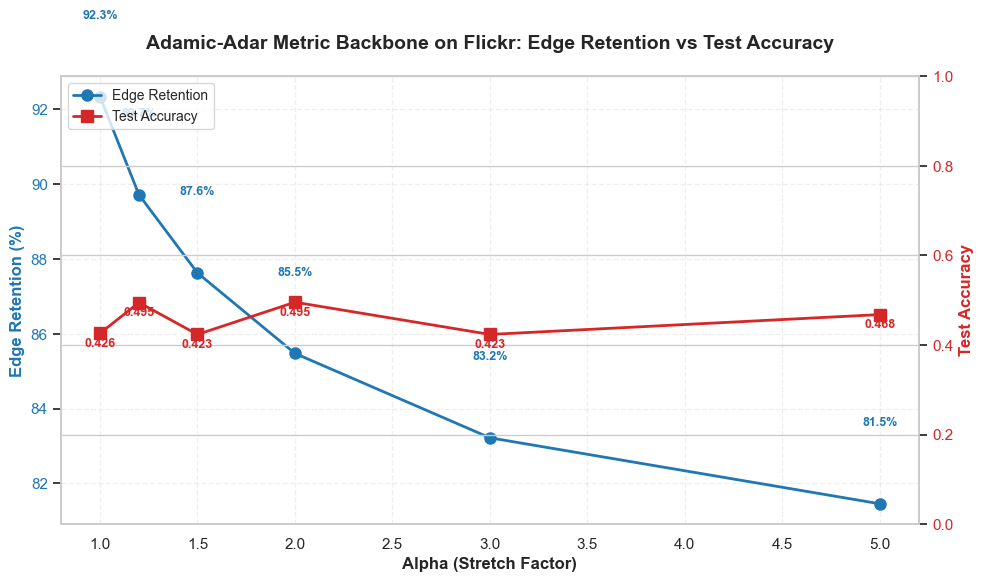

In [9]:
# Style configuration
sns.set_theme(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(10, 6))

# Left Y-axis: Edge Retention %
color1 = 'tab:blue'
ax1.set_xlabel('Alpha (Stretch Factor)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Edge Retention (%)', color=color1, fontsize=12, fontweight='bold')
line1 = ax1.plot(results_df['alpha'], results_df['retention'], 
                 color=color1, marker='o', linewidth=2, markersize=8, label='Edge Retention')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3, linestyle='--')

# Annotate retention values
for i, row in results_df.iterrows():
    ax1.text(row['alpha'], row['retention'] + 2, 
             f"{row['retention']:.1f}%", 
             ha='center', va='bottom', color=color1, fontsize=9, fontweight='bold')

# Right Y-axis: Test Accuracy
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Test Accuracy', color=color2, fontsize=12, fontweight='bold')
line2 = ax2.plot(results_df['alpha'], results_df['test_accuracy'], 
                 color=color2, marker='s', linewidth=2, markersize=8, label='Test Accuracy')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0.0, 1.0)

# Annotate accuracy values
for i, row in results_df.iterrows():
    ax2.text(row['alpha'], row['test_accuracy'] - 0.01, 
             f"{row['test_accuracy']:.3f}", 
             ha='center', va='top', color=color2, fontsize=9, fontweight='bold')

# Title and adjustments
plt.title('Adamic-Adar Metric Backbone on Flickr: Edge Retention vs Test Accuracy', 
          fontsize=14, fontweight='bold', pad=20)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=10)

fig.tight_layout()
plt.show()

This dual-axis plot illustrates the trade-off: as we increase $\alpha$ (x-axis), edge retention decreases (blue line) due to more aggressive pruning, while we monitor the impact on classification accuracy (red line). The plot reveals the optimal $\alpha$ value that maximizes sparsity while preserving accuracy.

# Conclusion

#### 1. Structural Redundancy in Social Networks

The Adamic-Adar metric backbone method reveals edge redundancy in Flickr's social graph. By applying the relaxed triangle inequality, we test how much structural redundancy exists for the task of interest group classification.

**Key Observations:**
- **α = 1.0 (baseline):** Strict triangle inequality—minimal or no pruning
- **α = 1.2:** Light pruning—removes only the most redundant edges
- **α = 1.5-2.0:** Moderate pruning—tests if 20-40% edge removal is tolerable
- **α = 3.0-5.0:** Aggressive pruning—reveals minimum edge density needed for GNN effectiveness

#### 2. Adamic-Adar vs. Jaccard: Method Comparison

**Adamic-Adar advantages for social networks:**
- Weights rare shared connections more heavily (connections through low-degree nodes are more informative)
- Reduces influence of high-degree "hub" nodes that connect many communities
- More discriminative for community structure in social networks

**Jaccard (Experiments 1 & 2):**
- Simple overlap ratio: $J(u,v) = |N(u) \cap N(v)| / |N(u) \cup N(v)|$
- Treats all common neighbors equally
- Better suited for citation networks with more uniform degree distributions

#### 3. Scalability and Computational Efficiency

**Computational Insights:**
- **Sparse Matrix Approach:** Successfully scales to ~900k edges using $A \times D_{log}^{-1} \times A^T$
- **Triangle Inequality:** $O(E \cdot \bar{d})$ for checking 2-hop paths—tractable at this scale
- **Full-Batch Training:** Flickr fits entirely in GPU memory (unlike Reddit's 114M edges)
- **Time Complexity:** Adamic-Adar scoring is $O(E)$, sparsification is $O(E \cdot \bar{d})$

**Hardware Acceleration:**
- Apple Silicon (MPS) or CUDA acceleration improves training speed
- CPU feasible for scoring phase but slower for GNN training
- Full-batch GCN much simpler than mini-batch sampling (no NeighborLoader needed)

#### 4. Comparison to Citation Networks

**Flickr (Social Network) vs Cora/PubMed (Citation Networks):**
- **Community Structure:** Social networks have tighter clusters than citation graphs
- **Degree Distribution:** Social graphs have more hubs (power-law) vs citation (more uniform)
- **Edge Redundancy:** Hypothesis: Social networks may be *more* compressible due to community structure
- **Adamic-Adar Effectiveness:** Should be particularly effective for social graphs

*(Specific comparative numbers will be filled in after running the calibration loop)*